In [271]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skimpy import skim


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno
import warnings 

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/Users/mengyanzhu/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py)

In [198]:
#Seaborn settings for visualizations!
rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette = 'YlOrRd'

sns.set(rc=rc)
pd.set_option('display.max_columns',35)
pd.options.display.float_format = '{:,.2f}'.format

In [199]:
file_name = '2023Q1_stat.csv'
baseTable_1 = pd.read_csv(file_name, low_memory=False)

n_row, n_col = baseTable_1.shape
print(f"Number of rows: {n_row}")
print(f"Number of columns: {n_col}")


Number of rows: 210810
Number of columns: 74


In [200]:
file_name = '2023Q2_stat.csv'
baseTable_2 = pd.read_csv(file_name, low_memory=False)

n_row, n_col = baseTable_2.shape
print(f"Number of rows: {n_row}")
print(f"Number of columns: {n_col}")

Number of rows: 276714
Number of columns: 74


In [201]:
file_name = '2023Q3_stat.csv'
baseTable_3 = pd.read_csv(file_name, low_memory=False)


In [202]:
file_name = '2023Q4_stat.csv'
baseTable_4 = pd.read_csv(file_name, low_memory=False)


In [203]:

baseTable_final = pd.concat([baseTable_1,baseTable_2,baseTable_3,baseTable_4])
baseTable_final.shape

(970186, 74)

In [204]:

baseTable_final.dropna(axis = 1, how = 'all', inplace= True)

In [205]:
baseTable_final.columns

Index(['LOAN_ID', 'ORIG_CHN', 'SELLER', 'orig_rt', 'orig_amt', 'orig_trm',
       'oltv', 'ocltv', 'num_bo', 'dti', 'CSCORE_B', 'FTHB_FLG', 'purpose',
       'PROP_TYP', 'NUM_UNIT', 'occ_stat', 'state', 'zip_3', 'mi_pct',
       'CSCORE_C', 'relo_flg', 'MI_TYPE', 'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE',
       'LAST_RT', 'LAST_UPB', 'msa', 'FCC_COST', 'PP_COST', 'AR_COST',
       'IE_COST', 'TAX_COST', 'NS_PROCS', 'CE_PROCS', 'RMW_PROCS', 'O_PROCS',
       'repch_flag', 'LAST_ACTIVITY_DATE', 'LPI_DTE', 'FCC_DTE', 'DISP_DTE',
       'SERVICER', 'F30_DTE', 'F60_DTE', 'F90_DTE', 'F120_DTE', 'F180_DTE',
       'FCE_DTE', 'F180_UPB', 'FCE_UPB', 'F30_UPB', 'F60_UPB', 'F90_UPB',
       'MOD_FLAG', 'FMOD_DTE', 'FMOD_UPB', 'MODIR_COST', 'MODFB_COST',
       'MODFG_COST', 'MODTRM_CHNG', 'MODUPB_CHNG', 'z_num_periods_120',
       'F120_UPB', 'CSCORE_MN', 'ORIG_VAL', 'LAST_DTE', 'LAST_STAT',
       'COMPLT_FLG', 'INT_COST', 'PFG_COST', 'NET_LOSS', 'NET_SEV',
       'MODTOT_COST'],
      dtype='object')

##### NET_LOSS=lambda x: np.round(np.where(
                    #####   x['COMPLT_FLG'] == 1,
                    #####   (x['LAST_UPB'] + x['FCC_COST'] + x['PP_COST'] + x['AR_COST'] + x['IE_COST'] +
                    #####    x['TAX_COST'] + x['PFG_COST'] + x['INT_COST'] + -1 * x['NS_PROCS'] + -1 * x['CE_PROCS'] +
                     #####   -1 * x['RMW_PROCS'] + -1 * x['O_PROCS']), np.nan), 2),

##### msa metropolitan statistic area
##### mi_type - mortgage insurance type - 
        # 1 = Borrower Paid
        # 2 = Lender Paid
        # 3 = Enterprise Paid *
       #  Null = No MI
##### repch_flag - Repurchase Make Whole Proceeds Flag Y/N - Amounts received by Fannie Mae under the terms of our representation and warranty arrangements for the repurchase of the mortgage loan or the subject property or loss reimbursement subsequent to property disposition 
##### fthb_flg - FIRST TIME home buyer Y/N
##### mod flag - if the mortgage is modified Y/N
##### PFG COST - PRINCIPAL_FORGIVENESS_AMOUNT A reduction of the UPB owed on a mortgage by a borrower that is formally agreed to by the lender and the borrower, usually in conjunction with a loan modification.
##### mi pct - The original percentage of mortgage insurance coverage obtained for an insured conventional mortgage loan and used following the occurrence of an event of default to calculate the insurance benefit, as defined by the underlying master primary insurance policy.
##### occ occupation status P = Principal S =  Second I =  Investor U = Unknown

##### Term Change (MODTRM_CHNG) and UPB Change (MODUPB_CHNG) Fields: These fields track changes in loan terms and balances due to modifications

#### z_num_periods_120' comparing the first delinquency date (F120_DTE) to the origination date 

#### fce ?
#### last is current

In [206]:
baseTable_final['AQSN_DTE'] = pd.to_datetime(baseTable_final['AQSN_DTE'])
baseTable_final['ORIG_DTE'] = pd.to_datetime(baseTable_final['ORIG_DTE'])
baseTable_final['FRST_DTE'] = pd.to_datetime(baseTable_final['FRST_DTE'])
baseTable_final['F30_DTE'] = pd.to_datetime(baseTable_final['F30_DTE'])
baseTable_final['F60_DTE'] = pd.to_datetime(baseTable_final['F60_DTE'])
baseTable_final['F90_DTE'] = pd.to_datetime(baseTable_final['F90_DTE'])
baseTable_final['F120_DTE'] = pd.to_datetime(baseTable_final['F120_DTE'])
baseTable_final['F180_DTE'] = pd.to_datetime(baseTable_final['F180_DTE'])
baseTable_final['FCE_DTE'] = pd.to_datetime(baseTable_final['FCE_DTE'])

baseTable_final['FCC_DTE'] = pd.to_datetime(baseTable_final['FCC_DTE'])
baseTable_final['DISP_DTE'] = pd.to_datetime(baseTable_final['DISP_DTE'])

baseTable_final = baseTable_final.rename(columns={
    'orig_rt': 'ORIG_RATE', 'orig_amt': 'ORIG_AMOUNT', 'orig_trm': 'ORIG_TERM',
    'ocltv': 'OCLTV', 'num_bo': 'NUM_BO', 'dti': 'DTI', 'FTHB_FLG': 'FTHB_FLAG',
    'purpose': 'PURPOSE', 'PROP_TYP': 'PROP_TYPE', 'occ_stat': 'OCC_STAT', 'mi_pct': 'MI_PCT'
})


In [207]:

#delinquency flag
filtered_df = baseTable_final.assign(dlq_flg=lambda x: np.where(pd.notna(x['F30_DTE']), 1, 0))




In [208]:
baseTable = filtered_df[filtered_df['AQSN_DTE'] >= '2023-01-01']

In [209]:
baseTable.columns

Index(['LOAN_ID', 'ORIG_CHN', 'SELLER', 'ORIG_RATE', 'ORIG_AMOUNT',
       'ORIG_TERM', 'oltv', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLAG',
       'PURPOSE', 'PROP_TYPE', 'NUM_UNIT', 'OCC_STAT', 'state', 'zip_3',
       'MI_PCT', 'CSCORE_C', 'relo_flg', 'MI_TYPE', 'AQSN_DTE', 'ORIG_DTE',
       'FRST_DTE', 'LAST_RT', 'LAST_UPB', 'msa', 'FCC_COST', 'PP_COST',
       'AR_COST', 'IE_COST', 'TAX_COST', 'NS_PROCS', 'CE_PROCS', 'RMW_PROCS',
       'O_PROCS', 'repch_flag', 'LAST_ACTIVITY_DATE', 'LPI_DTE', 'FCC_DTE',
       'DISP_DTE', 'SERVICER', 'F30_DTE', 'F60_DTE', 'F90_DTE', 'F120_DTE',
       'F180_DTE', 'FCE_DTE', 'F180_UPB', 'FCE_UPB', 'F30_UPB', 'F60_UPB',
       'F90_UPB', 'MOD_FLAG', 'FMOD_DTE', 'FMOD_UPB', 'MODIR_COST',
       'MODFB_COST', 'MODFG_COST', 'MODTRM_CHNG', 'MODUPB_CHNG',
       'z_num_periods_120', 'F120_UPB', 'CSCORE_MN', 'ORIG_VAL', 'LAST_DTE',
       'LAST_STAT', 'COMPLT_FLG', 'INT_COST', 'PFG_COST', 'NET_LOSS',
       'NET_SEV', 'MODTOT_COST', 'dlq_flg'],
  

In [210]:
model_table = baseTable.loc[:, ['ORIG_CHN', 'ORIG_RATE', 'ORIG_AMOUNT',
       'ORIG_TERM', 'oltv', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLAG',
       'PURPOSE', 'PROP_TYPE', 'NUM_UNIT', 'OCC_STAT', 'state', 'zip_3',
       'MI_PCT', 'CSCORE_C', 'relo_flg', 'MI_TYPE',
        'msa', 'dlq_flg']]

### Delinquency flag

In [211]:

model_table['dlq_flg'].value_counts(normalize=True)

dlq_flg
0   0.97
1   0.03
Name: proportion, dtype: float64

### Univariate Analysis

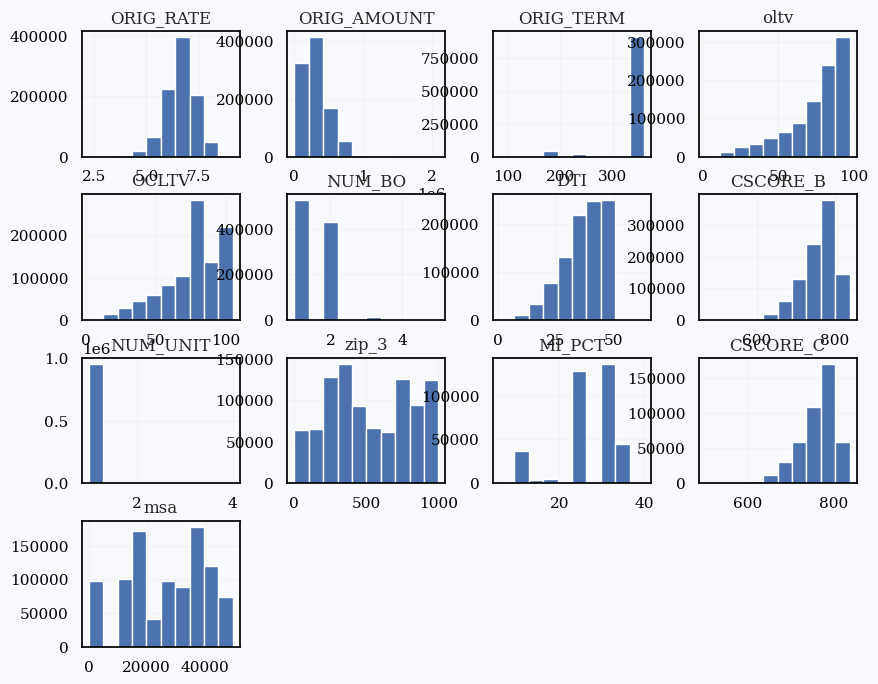

In [212]:

model_table.drop('dlq_flg', axis=1).hist(figsize=(10,8));

### Bivariate Analysis and heat Map

In [213]:
model_table.corr(method='pearson', numeric_only=True)
fig = go.Figure(go.Heatmap(z=model_table.corr(method='pearson', numeric_only=True), x=model_table.corr(method='pearson', numeric_only=True).columns.tolist(), y=model_table.corr(method='pearson', numeric_only=True).corr().columns.tolist(), colorscale='agsunset'))
fig.show()

#### split dataset

In [256]:
X = model_table.drop('dlq_flg', axis=1)
y = model_table['dlq_flg']

TARGET = 'dlq_flg'
NUMERIC_COLS = [f for f in X._get_numeric_data().columns if f!= TARGET]
CAT_COLS     = list(X.drop(NUMERIC_COLS, axis = 1))
for col in CAT_COLS:
    X[col] = X[col].astype('category')

print(X.dtypes)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)


ORIG_CHN       category
ORIG_RATE       float64
ORIG_AMOUNT     float64
ORIG_TERM         int64
oltv            float64
OCLTV           float64
NUM_BO            int64
DTI             float64
CSCORE_B        float64
FTHB_FLAG      category
PURPOSE        category
PROP_TYPE      category
NUM_UNIT          int64
OCC_STAT       category
state          category
zip_3             int64
MI_PCT          float64
CSCORE_C        float64
relo_flg       category
MI_TYPE        category
msa               int64
dtype: object


In [257]:
X_train.head(1)


,ORIG_CHN,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,oltv,OCLTV,NUM_BO,DTI,CSCORE_B,FTHB_FLAG,PURPOSE,PROP_TYPE,NUM_UNIT,OCC_STAT,state,zip_3,MI_PCT,CSCORE_C,relo_flg,MI_TYPE,msa
61721,R,5.99,"523,000.00",360,95.00,95.00,2,41.00,688.00,Y,P,SF,1,P,CT,63,30.00,721.00,N,BPMI,35980


#### Missing Values

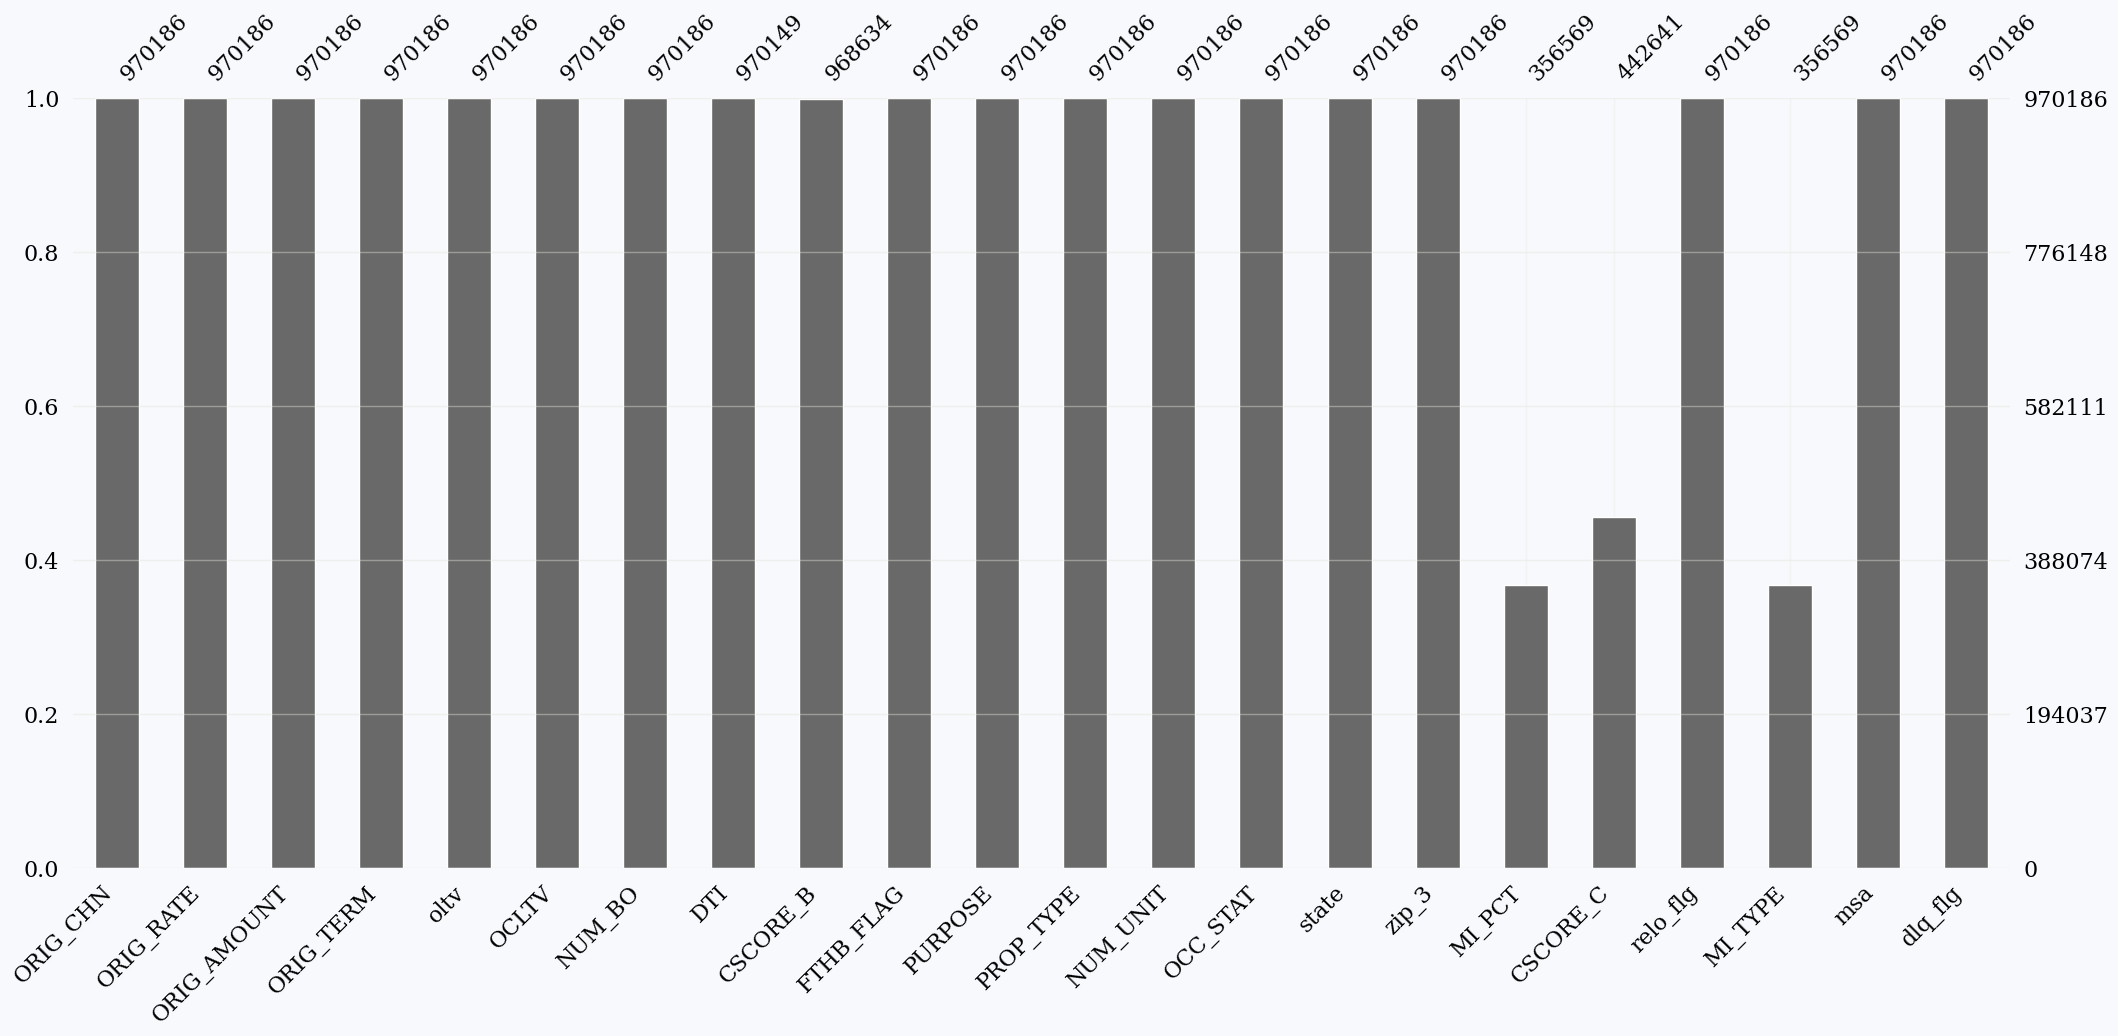

In [216]:
msno.bar(model_table)

#### Here use median for missing values as data is skewed

In [258]:
def NullFill(df):
    x_copy =df.copy()
    for c in CAT_COLS:                       
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna('None')
    
    for c in NUMERIC_COLS:
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna(x_copy[c].median())
                
        
    return x_copy

NullImputer = FunctionTransformer(NullFill)

In [259]:
X_train['CSCORE_C'] = X_train['CSCORE_C'].fillna(X_train['CSCORE_B'])

#### One hot encoder

In [260]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), CAT_COLS),
          ('num', 'passthrough', NUMERIC_COLS)
    ],
     # Drop non-specified columns
)


In [261]:
print(X_train.dtypes)
print(X_test.dtypes)
print(X_train.isnull().sum())
print(X_test.isnull().sum())

ORIG_CHN       category
ORIG_RATE       float64
ORIG_AMOUNT     float64
ORIG_TERM         int64
oltv            float64
OCLTV           float64
NUM_BO            int64
DTI             float64
CSCORE_B        float64
FTHB_FLAG      category
PURPOSE        category
PROP_TYPE      category
NUM_UNIT          int64
OCC_STAT       category
state          category
zip_3             int64
MI_PCT          float64
CSCORE_C        float64
relo_flg       category
MI_TYPE        category
msa               int64
dtype: object
ORIG_CHN       category
ORIG_RATE       float64
ORIG_AMOUNT     float64
ORIG_TERM         int64
oltv            float64
OCLTV           float64
NUM_BO            int64
DTI             float64
CSCORE_B        float64
FTHB_FLAG      category
PURPOSE        category
PROP_TYPE      category
NUM_UNIT          int64
OCC_STAT       category
state          category
zip_3             int64
MI_PCT          float64
CSCORE_C        float64
relo_flg       category
MI_TYPE        category
ms

In [272]:
model = XGBClassifier(enable_categorical=True, eval_metric='logloss')

pipeline = ImbPipeline(steps=[('smote', SMOTE()), ('imputer', NullImputer),
                       ('encode',preprocessor), 
                        ('scaler', StandardScaler()), ('model', model)])



NameError: name 'ImbPipeline' is not defined

In [268]:
kfold = KFold(n_splits=10, random_state=42,shuffle= True)
results = cross_val_score(model, X, y, cv=kfold)
print(f'Accuracy: Results Mean : %{round(results.mean()*100,3)}, Results Standard Deviation : {round(results.std()*100,3)}')

Accuracy: Results Mean : %97.014, Results Standard Deviation : 0.037
